# Meshing introduction

gdsfactory has interfaces to external meshers (currently: [gmsh](https://gmsh.info/)).

Using a gdsfactory `Component` and a `Layerstack` reflecting the post-fabrication structure, you can automatically generate a 2D or 3D mesh suitable for physical simulation.

Within gdsfactory, this interface is currently used for:

* [finite-volume](https://en.wikipedia.org/wiki/Finite_volume_method) simulation through a [DEVSIM](https://devsim.org/) plugin, for e.g. TCAD simulations
* [finite-element](https://en.wikipedia.org/wiki/Finite_element_method) simulation through the [femwell](https://github.com/HelgeGehring/femwell) wrapper around [scikit-fem](https://scikit-fem.readthedocs.io/en/latest/), for e.g. mode solving and thermal simulations

Current features include:

* GDS postprocessing -- common interface for layout and simulation
* A generic shapely <--> gmsh translator, which properly reuses gmsh objects, resulting in conformal handling of
    * lateral interfaces
    * vertical interfaces
    * polygon inclusions
    * polygon "holes"
* 2D meshing of in-plane cross-sections (e.g. x - y)
* 2D meshing of out-of-plane cross-sections (e.g. arbitrary xy line - z)
* (In progress) 3D meshing
* The mesh is returned tagged with LayerStack `label` for each GDS layer according to a specific `mesh_order`
* All interfaces between layer entities are also tagged as `label1___label2` to e.g. implement interfacial boundary conditions
* Dummy layers can be easily introduced in a component to provide extra lines and polygons with custom labels to e.g. implement boundary conditions, sources, etc.
* Coarse resolution setting per label, and around interfaces
* Fine resolution setting with callable `[x,y,z,mesh_size]` functions (useful for simulation-driven refinement)

### Philosophy

GMSH can be used one of two ways:

* The traditional “bottom-up” way, where the user manually defines points, then line segments (from points), then lines (from segments), then closed curves (from lines), then surfaces (from curves), then closed shells (from surfaces), and finally volumes (from shells).
* With CAD-type boolean operations (set operations on objects)

While the latter method is much simpler for complex geometries, as of 2022 it does not preserve physical and mesh information, requiring manual "retagging" of the entities after the boolean operations, and driving its complexity back to bottom-up construction (especially for arbitrary geometries).

As such, gdsfactory uses the first approach, where the mask layers and a layerstack are used as a guide to define the various physical entities, which are returned as tagged objects to the user.

## Installation

You can install the meshing plugins with `pip install gdsfactory[gmsh]`.

Because PyVista does not work properly on headless systems we use Meshio.

## Usage

First, you can start with a gdsfactory `Component`

In [1]:
import meshio
from skfem.io import from_meshio

from gdsfactory.simulation.gmsh.mesh import create_physical_mesh
from gdsfactory.generic_tech import LAYER_STACK
from gdsfactory.technology import LayerStack
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

waveguide = gf.components.straight_pin(length=10, taper=None)
waveguide

2023-02-20 17:55:47.699 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.43.1


2023-02-20 17:55:48.949 | INFO     | gdsfactory.technology.layer_views:__init__:785 - Importing LayerViews from YAML file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/layer_views.yaml.


2023-02-20 17:55:48.955 | INFO     | gdsfactory.pdk:activate:206 - 'generic' PDK is now active


AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

straight_pin_length10_taperNone: uid 052a0254, ports ['o1', 'o2', 'bot_e1', 'bot_e2', 'bot_e3', 'bot_e4', 'top_e1', 'top_e2', 'top_e3', 'top_e4'], references ['straight_1', 'via_stack_1', 'via_stack_2'], 0 polygons


and a `LayerStack`. Here, we copy the example from `gdsfactory.generic_tech` for clarity).
The `info` dict contains miscellaneous information about the layers, including `mesh_order`, which determines which layer will appear in the mesh if layers overlap.

We can filter this stack to only focus on some layers:

In [2]:
filtered_layerstack = LayerStack(
    layers={
        k: LAYER_STACK.layers[k]
        for k in (
            "slab90",
            "core",
            "via_contact",
        )
    }
)

In [3]:
filename = "mesh"
def mesh_with_physicals(mesh, filename):
    mesh_from_file = meshio.read(f"{filename}.msh")
    return create_physical_mesh(mesh_from_file, "triangle", prune_z=True)

In [4]:
scene = waveguide.to_3d(layer_stack=filtered_layerstack)
scene.show()

trimesh: threejs viewer

The various processing and meshing functions are located under `gdsfactory.simulation.gmsh` and can be called from there, but a shortcut is implemented to mesh directly from a component:

In [5]:
mesh = waveguide.to_gmsh(
    type="xy", z=0.09, layer_stack=filtered_layerstack, filename="mesh.msh"
)

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.inte

This returns a gmsh `.msh` mesh, also saved in `filename` if provided, which can be processed:

[]

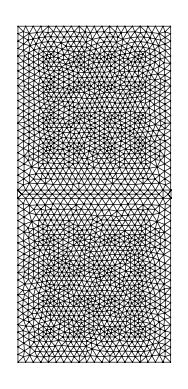

In [6]:
mesh.get_cells_type("triangle")
mesh = from_meshio(mesh)
mesh.draw().plot()

The `gmsh` GUI can be used to load and inspect the `.msh` file:

![msh mesh](https://imgur.com/jzwjEVC.png)

[meshio](https://github.com/nschloe/meshio) can also be used to convert the `.msh` to another arbitrary format, to observe for instance with `Paraview`. This is useful, for instance to preprocess the `msh` file using the `create_mesh` utility in order to consolidate entities with the same label:

[]

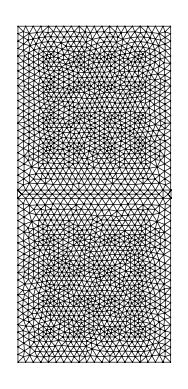

In [7]:
mesh_from_file = meshio.read("mesh.msh")

triangle_mesh = create_physical_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write("mesh.xdmf", triangle_mesh)

mesh = mesh_with_physicals(triangle_mesh, filename)
mesh = from_meshio(mesh)
mesh.draw().plot()

You can opening the `mesh.xdmf` in paraview:

![](https://imgur.com/zBn5596.png)

[]

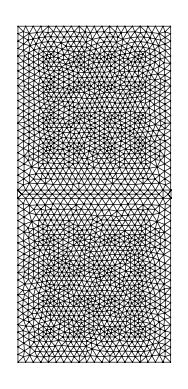

In [8]:
line_mesh = create_physical_mesh(mesh_from_file, "line", prune_z=True)
meshio.write("facet_mesh.xdmf", line_mesh)

mesh = mesh_with_physicals(line_mesh, filename)
mesh = from_meshio(mesh)
mesh.draw().plot()

Opening the `facet_mesh.xdmf` in paraview:

![](https://imgur.com/tNhIIPK.png)

The `xdmf` files with consolidated physical groups can also be opened dynamically in a notebook with `pyvista`